# Statistika Nejlepich pisnicek Spotify
>Data byla získana z webu kaggle (https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023).<br>
### Popis dat:<br>
- __Best Songs on Spotify from 1996-2023:__<br>
tabulka s nasledujícími sloupci: <br>
title,artist,top genre,year,bpm,energy,danceability ,dB,liveness,valence,duration,acousticness,speechiness ,popularity,,
<br>

    

In [ ]:
import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install pingouin

import pingouin 
import numpy
import plotly
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [44]:
table = pd.read_csv('.\Songs.csv', delimiter=';')
popularity = pd.read_csv(".\Songs.csv", usecols=['popularity'], delimiter=';')

table.head()
pingouin.print_table(table)
#table.describe()
#print(popularity)
#print(table)
#popularity.describe()


title                                                                                                artist                                     top genre                      year    bpm    energy    danceability    dB    liveness    valence    duration    acousticness    speechiness    popularity
---------------------------------------------------------------------------------------------------  -----------------------------------------  ---------------------------  ------  -----  --------  --------------  ----  ----------  ---------  ----------  --------------  -------------  ------------
Flowers                                                                                              Miley Cyrus                                pop                            2023    118        68              71    -4           3         65         200               6              7            98
Cupid - Twin Ver.                                                                                    FI

### 1 
Budeme zkoumat, zda delka pisnicek je dobře modelovana normálním rozdělením. <br>
H0 ... <br>
.. <br>

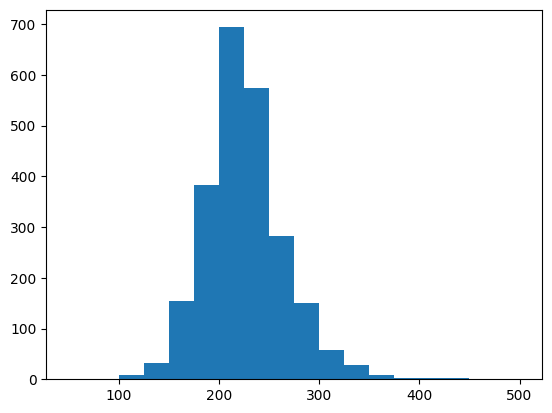

count    2385.000000
mean      225.946751
std        43.226704
min       115.000000
25%       200.000000
50%       221.000000
75%       246.000000
max       688.000000
Name: duration, dtype: float64

In [29]:
duration = table['duration'] #duration in seconds
#print(duration)
#plt.style.use('ggplot')
plt.hist(duration, bins=[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], color='tab:blue')
#plt.hist(duration, 20, color='tab:cyan')
#plt.hist(duration, bins=[100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400])
plt.show()
duration.describe()

Ted spocteme prumer, smerodatnou odchulku a rozptyl

In [30]:
duration_mean = duration.mean()
print(duration_mean)
duration_var = duration.var()
print(numpy.var(duration))
print(duration_var)
duration_std = numpy.std(duration)
print("deviation = ", duration_std)

225.946750524109
1867.7644600908015
1868.547918337484
deviation =  43.21764061226389


Vytvorim vektorove intervaly pro delku pisnicek <150, <200, <250, <300 , <350, <400, <450, <500, <550, >=550. (Nove verze <150, <225, <300, <375 , <450, >=450) Spocteme pocet pisnocek pro kazdy interval a pro kazdy interval spocteme z-skore. Z-skore pocitame jako podil, kde v citateli je rozdil horni hranice a prumeru a a ve jmenovateli smerodatna odchylka.

In [31]:
bounds = [120, 180, 240, 300, 360]
sum_bounds = [0, 0, 0, 0, 0, 0]
#sum_bounds[0] = sum(x < bounds[0] for x in duration)
sum_bounds[0] = sum(duration < bounds[0])
#sum_bounds[9] = sum(x >= bounds[8] for x in duration)
sum_bounds[5] = sum(duration >= bounds[4])
for i in range(1, len(bounds)):
    #print(i)
#    sum_bounds[i] = sum(x < bounds[i] for x in duration) - sum(x < bounds[i-1] for x in duration)
    sum_bounds[i] = sum(duration < bounds[i]) - sum(duration < bounds[i-1])

print(sum_bounds)
print(sum(sum_bounds))
z_score = [0, 0, 0, 0, 0, 0]
for i in range(0, len(bounds)):
    z_score[i] = (bounds[i]- duration_mean)/duration_std
print(z_score)
#Ze z skóre spočítám plochu pod křivkou normální distribuce N(0,1)
area_under = [0, 0, 0, 0, 0, 0]
for i in range(len(z_score)):
    #print(i)
    area_under[i] = stats.norm.cdf(z_score[i])
area_under[len(area_under)-1] = 1
print(area_under)

[2, 255, 1408, 614, 90, 16]
2385
[-2.4514700252758463, -1.0631480542015215, 0.32517391687280345, 1.7134958879471283, 3.101817859021453, 0]
[0.007113701783713703, 0.14385740755201204, 0.6274752758867737, 0.9566893253931492, 0.9990383186982759, 1]


Dále spočítám plochu v rámci intervalů

In [32]:
area_inside = [0, 0, 0, 0, 0, 0]
area_inside[0] = round(area_under[0], 8)

for i in range(1, len(area_under)):
    x = area_under[i] - area_under[i-1]
    area_inside[i] = round(x, 8)
    #print(round(area_inside[i]*100, 2))
print(area_inside)
print(sum_bounds)

[0.0071137, 0.13674371, 0.48361787, 0.32921405, 0.04234899, 0.00096168]
[2, 255, 1408, 614, 90, 16]


Plochu v rámci intervalů využiji jako očekávané pravděpodobnosti pro chí-kvadrát test.

In [33]:
sum_elements = sum(sum_bounds)
#print(sum_elements)

#for i in range(len(sum_bounds)):
#    sum_bounds[i] = sum_bounds[i] / sum_elements
#    print(sum_bounds[i])

for i in range(len(area_inside)):
    area_inside[i] = area_inside[i] * sum_elements
    #print(area_inside[i])



chi = 0
#for i in range(len(area_inside)):
 #   print(i)
 #   chi = chi + ((sum_bounds[i] - area_inside[i])^2)/area_inside[i]  
#print(chi)    

stats.chisquare(sum_bounds, f_exp=area_inside)

Power_divergenceResult(statistic=205.3276643003221, pvalue=2.058183074578902e-42)

p-value vysla mensi nez 0.05, takze hypotezu zamitneme

Ještě je možné podívat se na Q-Q plot (quantile - quantile plot)

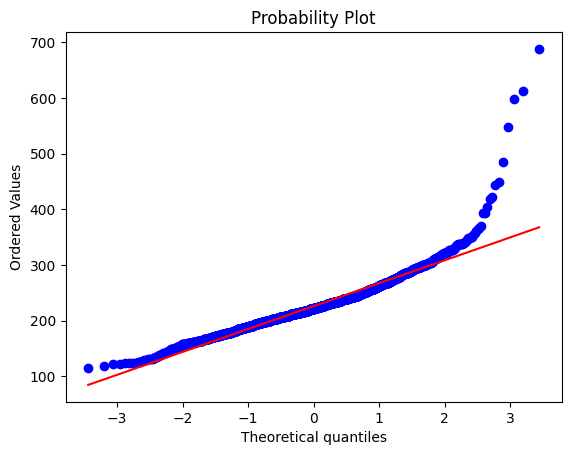

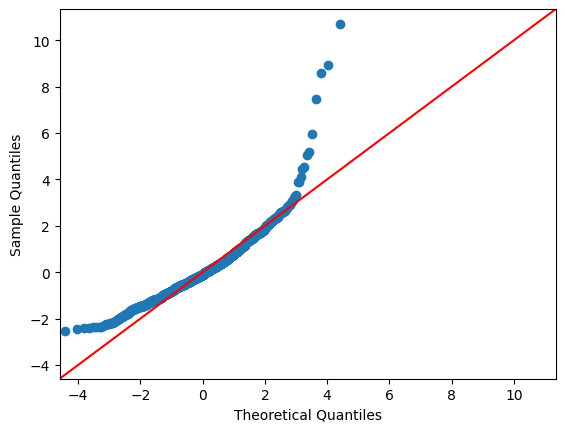

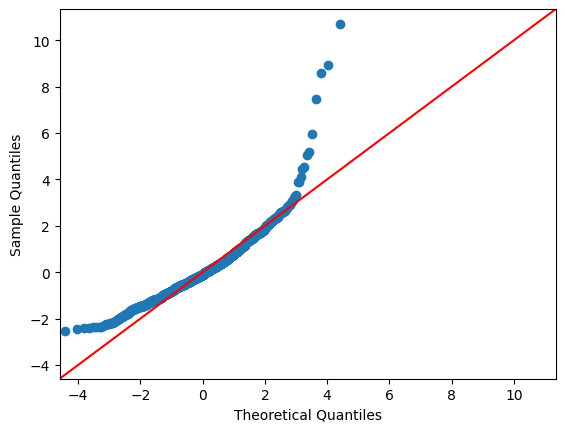

In [34]:
stats.probplot(duration, dist="norm", plot=plt)
plt.show()
sm.qqplot(duration, stats.t, fit=True, line='45') 



Shapiro test

ShapiroResult(statistic=0.906105101108551, pvalue=5.1749929866740065e-36)
0.906105101108551
                 W          pval  normal
duration  0.906105  5.174993e-36   False


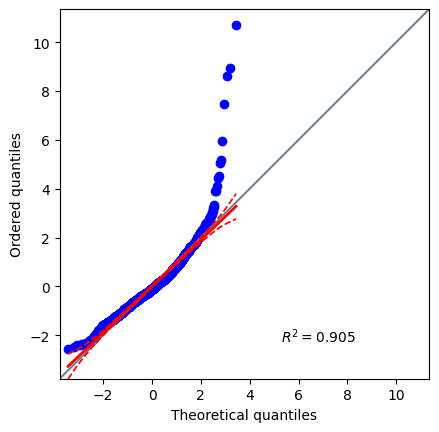

In [35]:
res = stats.shapiro(duration)
print(res)
print(res.statistic) # The value of this statistic tends to be high (close to 1) for samples drawn from a normal distribution.
print(pingouin.normality(duration))
ax = pingouin.qqplot(duration, dist='norm')

### 2

Zavislost mezi popularity a danceability or speechiness?? Linearni regrese.<br>
H0: popularita nezalezi na speechiness <br>
Alternativni hypoteza: bla-bla

In [36]:
popularity = table['popularity']
speechiness = table['speechiness']
popularity.describe()
speechiness.describe()


count    2385.000000
mean       10.112369
std         9.520815
min         2.000000
25%         4.000000
50%         6.000000
75%        12.000000
max        58.000000
Name: speechiness, dtype: float64

Připravím si model lineární regrese, vynesu si data do grafu, proložím daty přímku a podívám se, jak data vypadají.

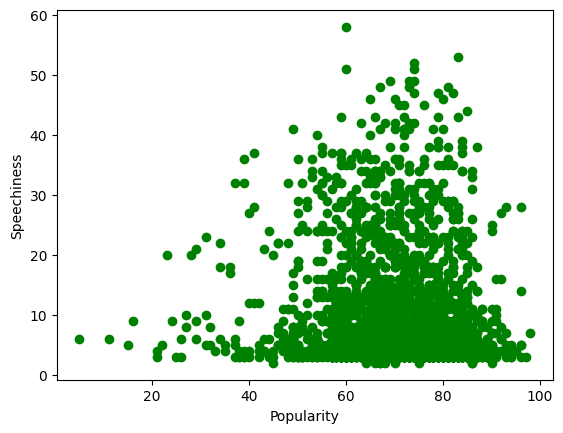

The linear model is: Y = 14.385 + -0.060586X
        names       coef        se          T          pval        r2   
0   Intercept  14.385303  1.216961  11.820674  2.255219e-31  0.005281  \
1  popularity  -0.060586  0.017034  -3.556862  3.826318e-04  0.005281   

     adj_r2   CI[2.5%]  CI[97.5%]  
0  0.004864  11.998891  16.771716  
1  0.004864  -0.093988  -0.027184  


In [43]:
x = popularity.values.reshape(-1, 1)
y = speechiness.values.reshape(-1, 1)

reg = LinearRegression().fit(x, y)

#print("Coefficients: \n", reg.coef_)
#print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

fig, ax = plt.subplots()
#ax.set_title('Example Graph')
ax.set_ylabel('Speechiness')
ax.set_xlabel('Popularity')

plt.scatter(x, y, color="green")

#plt.plot(x_test, y_pred, color="blue", linewidth=2)
plt.show()

reg.score(x, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
res = pingouin.linear_regression(popularity, speechiness)
print(res)

Poté spočítám průměr  **speechiness** a průměr popularity.

In [38]:
speechiness_mean = speechiness.mean()
popularity_mean = popularity.mean()
print(speechiness_mean, popularity_mean)

10.112368972746332 70.5266247379455


Spočítám a a b pro regresi.

In [39]:
suma = 0
a = 0
for i in range(len(speechiness)):
    a += (popularity[i] - popularity_mean)*(speechiness[i] - speechiness_mean)
    suma =  suma + (popularity[i]-popularity_mean)**2

a = a/suma
b = speechiness_mean - a*popularity_mean
print(a, b)

-0.06058611358770582 14.385303070077


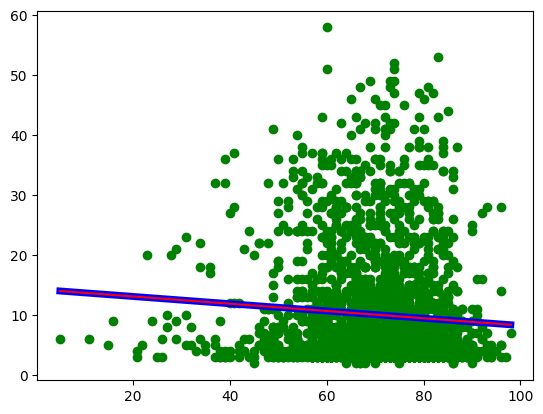

In [40]:
plt.scatter(x, y, color="green")

predictions = reg.predict(x)
#plt.plot(x_test, y_pred, color="blue", linewidth=2)
plt.plot(
    x,
    predictions,
    c='blue',
    linewidth=5
)
plt.plot(x, a*x+b, c='red')
plt.show()


Nejaky zaver ...  https://towardsdatascience.com/the-complete-guide-to-linear-regression-in-python-3d3f8f06bf8 

In [42]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.65
Date:                Sat, 08 Jul 2023   Prob (F-statistic):           0.000383
Time:                        09:32:28   Log-Likelihood:                -8751.9
No. Observations:                2385   AIC:                         1.751e+04
Df Residuals:                    2383   BIC:                         1.752e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3853      1.217     11.821      0.0

In [ ]:
print(est2.pvalues[1]) #https://www.statology.org/statsmodels-linear-regression-p-value/

0.0003826317979757927


Reversed dependence: the less speechiness, the more popular

### 3
Zavislost mezi popularitou a dansability. H0 neni zacislost

The linear model is: Y = 68.686 + -0.023415X


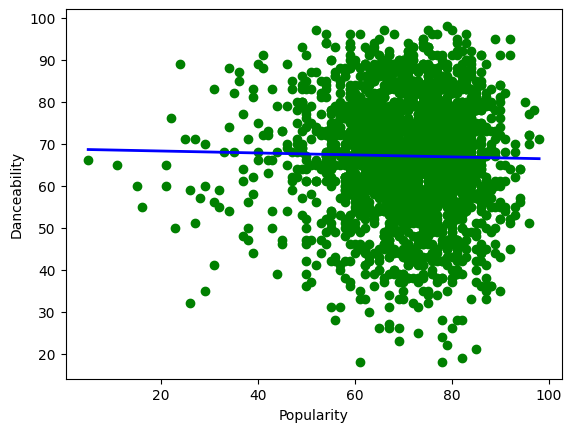

In [ ]:
popularity = table['popularity']
dance = table['danceability']

x = popularity.values.reshape(-1, 1)
y = dance.values.reshape(-1, 1)

reg = LinearRegression().fit(x, y)


fig, ax = plt.subplots()
ax.set_ylabel('Danceability')
ax.set_xlabel('Popularity')

plt.scatter(x, y, color="green")

#plt.plot(x_test, y_pred, color="blue", linewidth=2)


reg.score(x, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

predictions = reg.predict(x)
#plt.plot(x_test, y_pred, color="blue", linewidth=2)
plt.plot(
    x,
    predictions,
    c='blue',
    linewidth=2
)
plt.show()


In [ ]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print(est2.pvalues[1]) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9056
Date:                Sat, 08 Jul 2023   Prob (F-statistic):              0.341
Time:                        09:07:52   Log-Likelihood:                -9629.0
No. Observations:                2385   AIC:                         1.926e+04
Df Residuals:                    2383   BIC:                         1.927e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.6862      1.758     39.073      0.0

neni linearni zavislost mezi tim

### 4 Tempo hudby
“Beats per minute” (or BPM) is self-explanatory: it indicates the number of beats in one minute. For instance, a tempo notated as 60 BPM would mean that a beat sounds exactly once per second. A 120 BPM tempo would be twice as fast, with two beats per second. <br>
Stredni hodnota bpm 00-09 roku a stredni hodnota bpm 10-19 roku<br>
H0: nelisi se
Alternativni: lisi se

Provedeme dvou vyberovy test. Priprava dat

In [48]:
zeroes = []
tens = []
years = table['year']
bpms = table['bpm']
for i in range(len(years)):
    if years[i] > 2009:
        tens.append(bpms[i])
    else:
        if years[i] > 1999:
            zeroes.append(bpms[i])


result = stats.ttest_ind(zeroes, tens, equal_var=False, alternative='two-sided')
#result.confidence_interval(confidence_level=0.95)
print(result)
#plt.hist(tens)
#plt.show()
res = pingouin.ttest(zeroes, tens)
print(res)

Ttest_indResult(statistic=-0.926464309439658, pvalue=0.3543207988658451)
               T          dof alternative     p-val          CI95%   cohen-d   
T-test -0.926464  1926.210783   two-sided  0.354321  [-3.37, 1.21]  0.039589  \

         BF10     power  
T-test  0.073  0.155471  


Protoze p-value je vetsi nez hladina vyznamnosti, takze prijimame nulovou hypotezu. Z toho lze udelat zaver, ze tempo je celkem stejne pro oba desetileti

### 5 Valence
Valence: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

Zda jsou stredni hodnoty valence pisnocek stejne v prvni pulce nulovych roku a v poslednich letech. Roky pro porovnani 01-05 a 19-23

H0: stejne

Alternativni

In [58]:
before = []
during = []
valence  = table['valence']

for i in range(len(years)):
    if 2000 < years[i] < 2006:
        before.append(valence[i])
    elif 2018 < years[i] < 2024:
        during.append(valence[i])

print(len(before), len(during))

result = stats.ttest_ind(before, during, equal_var=False, alternative='two-sided')

print(result)

res = pingouin.ttest(before, during)
print(res)
print(numpy.mean(during), numpy.mean(before))

492 411
Ttest_indResult(statistic=7.633226890107983, pvalue=5.987604487666038e-14)
               T         dof alternative         p-val         CI95%   
T-test  7.633227  874.607766   two-sided  5.987604e-14  [8.51, 14.4]  \

         cohen-d       BF10  power  
T-test  0.509788  9.332e+10    1.0  
49.17761557177616 60.636178861788615


p-hodnota je mnohem mensi nez, hladina vyznamnosti, takze H0 zamitam a prijimam alternativni hypotezu. Celkove lze rici, ze valence na zacatku nulovych roku byla mensi, nez tedka